# Alzheimer's disease Classification

In this notebook, I will fit the models for Alzheimer's classification. I have three levels of disease Very Mild, Mild, and Moderate. They all have different numbers of images for training - imbalanced classes. My No Disease class has the most images and Modelate disease has very few images. My baseline is 50%. [Study](https://www.medscape.com/viewarticle/883192) showed that Alzheimer's disease classification accuracy from MRI scans is around 75%.

In [30]:
# Imports
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import EfficientNetV2S, Xception, resnet50
from tensorflow.keras.regularizers import l2
from keras.optimizers import Adam

import functions

import numpy as np
np.random.seed(18)

In [15]:
# The path to the training and testing sets
al_path_train = '../data/alzheimer/train'
al_path_test = '../data/alzheimer/test'

# Set image size
image_size = 240

# Set optimizer
learning_rate = 0.001 
optimizer = Adam(learning_rate=learning_rate)

# Set Early stopping
es = EarlyStopping(patience = 5, restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

## CNN model

In [4]:
# Load data fror training
al_train_ds, al_val_ds = image_dataset_from_directory(
    '../data/alzheimer/train',
    labels='inferred',
    label_mode='categorical',
    color_mode='grayscale',  # The images are black and wight
    batch_size=64,
    image_size=(image_size, image_size),
    seed=18,
    validation_split=0.2,
    subset = 'both'
)

Found 5121 files belonging to 4 classes.
Using 4097 files for training.
Using 1024 files for validation.


In [5]:
# Load data for Testing
al_test_ds = image_dataset_from_directory(
    '../data/alzheimer/test',
    labels='inferred',
    label_mode='categorical',
    color_mode='grayscale',  # The images are black and wight
    batch_size=64,
    image_size=(image_size, image_size),
    seed=18
)

Found 1279 files belonging to 4 classes.


In [7]:
model = Sequential()

model.add(layers.Input(shape=(image_size, image_size, 1)))
model.add(layers.Rescaling(1./255))

#First Convolution
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))
#Second Convolution
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))
#Third Convolution
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))
#Fourth Convolution
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

#Flatten
model.add(Flatten())
# Fully Connected
model.add(Dense(64, activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(64, activation = 'relu', kernel_regularizer=l2(0.0005)))
model.add(Dropout(0.2))
model.add(Dense(4, activation='softmax'))

# Compile
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

h = model.fit(al_train_ds, validation_data = al_val_ds, epochs=30, callbacks = [es, reduce_lr])

Epoch 1/30
65/65 [==============================] - 220s 3s/step - loss: 1.1269 - accuracy: 0.4686 - val_loss: 1.1744 - val_accuracy: 0.5107 - lr: 0.0010
Epoch 2/30
65/65 [==============================] - 225s 3s/step - loss: 1.0746 - accuracy: 0.4794 - val_loss: 1.1508 - val_accuracy: 0.5107 - lr: 0.0010
Epoch 3/30
65/65 [==============================] - 223s 3s/step - loss: 1.0607 - accuracy: 0.4838 - val_loss: 1.0133 - val_accuracy: 0.5107 - lr: 0.0010
Epoch 4/30
65/65 [==============================] - 222s 3s/step - loss: 1.0129 - accuracy: 0.5172 - val_loss: 0.9399 - val_accuracy: 0.5430 - lr: 0.0010
Epoch 5/30
65/65 [==============================] - 216s 3s/step - loss: 0.9491 - accuracy: 0.5502 - val_loss: 0.9561 - val_accuracy: 0.5547 - lr: 0.0010
Epoch 6/30
65/65 [==============================] - 180s 3s/step - loss: 0.9156 - accuracy: 0.5763 - val_loss: 0.8986 - val_accuracy: 0.5664 - lr: 0.0010
Epoch 7/30
65/65 [==============================] - 135s 2s/step - loss: 0.9

In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 240, 240, 1)       0         
                                                                 
 conv2d (Conv2D)             (None, 238, 238, 64)      640       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 119, 119, 64)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 119, 119, 64)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 117, 117, 64)      36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 58, 58, 64)       0         
 2D)                                                    

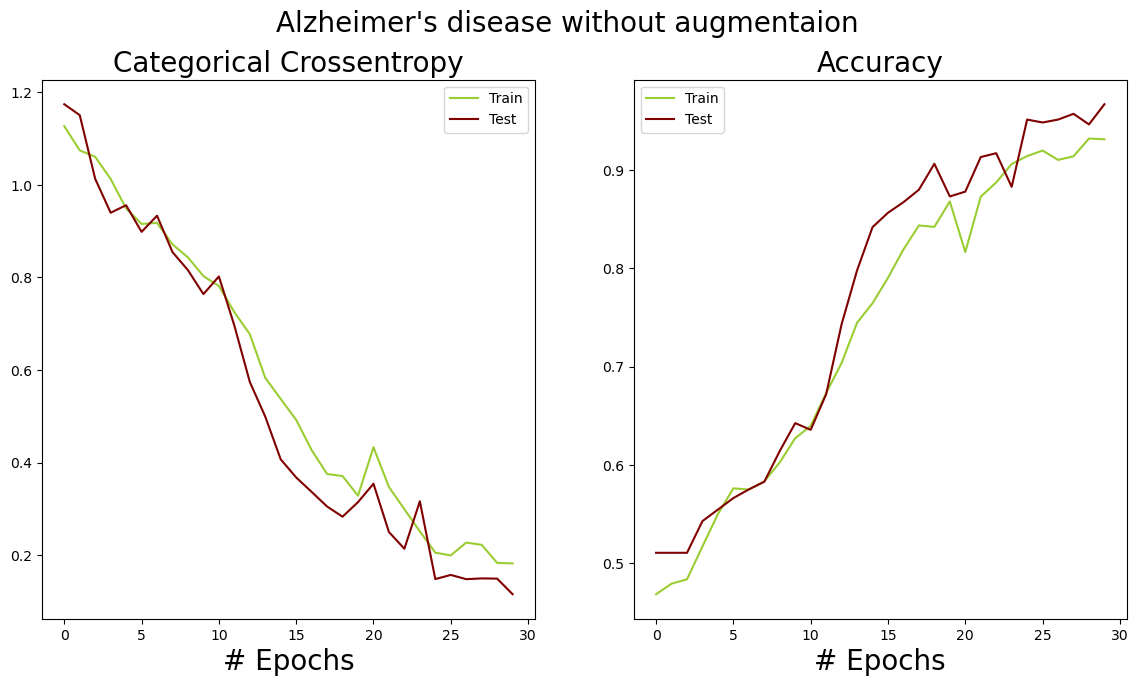

In [10]:
# Plot Crossentropy and Accuracy by epoch
functions.evaluation_plots(h, 'Alzheimer\'s disease without augmentaion')

Accuracy_score: 0.9668 



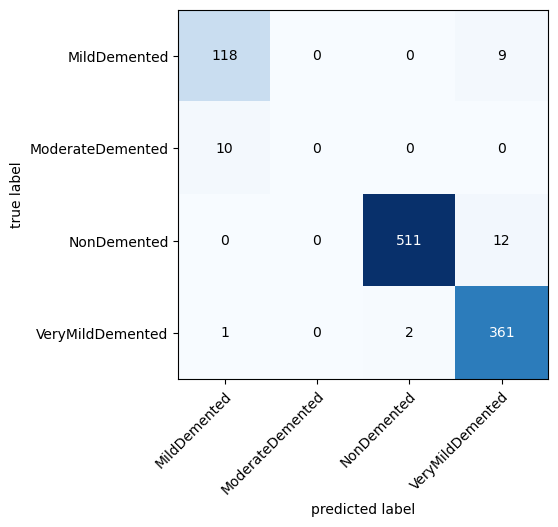

In [9]:
# Plot Confusion Matrix for Validation set
functions.acc_conf_matrix(model, val_data=al_val_ds)

Accuracy_score: 0.6747 



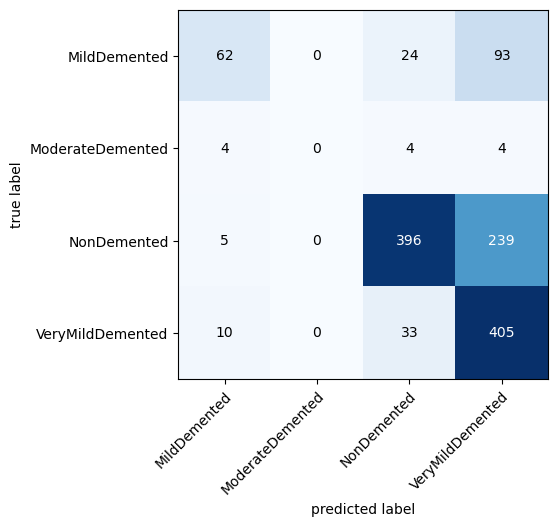

In [8]:
# Plot Confusion Matrix for Testing data
functions.acc_conf_matrix(model, val_data=al_test_ds)

The model performs very well on the validating set, except Moderate Alzheimer's. The model does not perform great on the test set, it is overfit. I have tried different Dropouts, learning rate and regularizations and this is my best model. The worst predicted is Modetate Demented. 

---

# Pre-trained models

Pre-trained models requare color images I will have to read the images separately and convert each to RGB. Inspired by https://stackoverflow.com/questions/51995977/how-can-i-use-a-pre-trained-neural-network-with-grayscale-images

In [11]:
# Read the images, convert to greyscale and prepare for Tensorflow models
X_train, X_val, y_train, y_val = functions.read_grey_images_to_rgb('../data/alzheimer/train')

# Check the shape of the data
X_train.shape, y_train.shape

((3840, 240, 240, 3), (3840, 4))

In [12]:
# Prepare the training data for predictions
X_test, y_test = functions.read_grey_images_to_rgb('../data/alzheimer/test', train_test = False)

# Check the shape of the data
X_test.shape, y_test.shape

((1279, 240, 240, 3), (1279, 4))

Another option for greyscale images is to read them as RGB

In [11]:
# Load data fror training
al_train_ds_rgb, al_val_ds_rgb = image_dataset_from_directory(
    '../data/alzheimer/train',
    labels='inferred',
    label_mode='categorical',
    batch_size=64,
    image_size=(image_size, image_size),
    seed=18,
    validation_split=0.2,
    subset = 'both'
)

Found 5121 files belonging to 4 classes.
Using 4097 files for training.
Using 1024 files for validation.


In [22]:
# Load data for Testing
al_test_ds_rgb = image_dataset_from_directory(
    '../data/alzheimer/test',
    labels='inferred',
    label_mode='categorical',
    batch_size=64,
    image_size=(image_size, image_size),
    seed=18
)

Found 1279 files belonging to 4 classes.


---

## EfficientNetV2S

In [16]:
effnet = EfficientNetV2S(
    include_top=False,
    weights="imagenet",
    input_shape=(image_size, image_size, 3),
    classes=4,
    classifier_activation="softmax",
    include_preprocessing=True,
)

In [17]:
# Freeze last 5 layers
for layer in effnet.layers[:-5]:
    layer.trainable = False

In [18]:
# Read images as RGB to use in pre-trained model

model = Sequential()

model.add(effnet)
model.add(GlobalAveragePooling2D())
model.add(Dropout(.2))

#Just use a single output layer
model.add(Dense(4, activation='softmax'))

# Compile
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

h_efv2s = model.fit(al_train_ds_rgb, validation_data = al_val_ds_rgb, epochs=30, callbacks=[es, reduce_lr])

Epoch 1/30
65/65 [==============================] - 402s 6s/step - loss: 0.9356 - accuracy: 0.5724 - val_loss: 0.8420 - val_accuracy: 0.5986 - lr: 0.0010
Epoch 2/30
65/65 [==============================] - 365s 6s/step - loss: 0.8128 - accuracy: 0.6270 - val_loss: 0.8198 - val_accuracy: 0.6484 - lr: 0.0010
Epoch 3/30
65/65 [==============================] - 358s 6s/step - loss: 0.7747 - accuracy: 0.6468 - val_loss: 0.7413 - val_accuracy: 0.6553 - lr: 0.0010
Epoch 4/30
65/65 [==============================] - 359s 6s/step - loss: 0.7358 - accuracy: 0.6739 - val_loss: 0.7123 - val_accuracy: 0.6670 - lr: 0.0010
Epoch 5/30
65/65 [==============================] - 361s 6s/step - loss: 0.7106 - accuracy: 0.6749 - val_loss: 0.7445 - val_accuracy: 0.6680 - lr: 0.0010
Epoch 6/30
65/65 [==============================] - 368s 6s/step - loss: 0.6825 - accuracy: 0.6961 - val_loss: 0.7542 - val_accuracy: 0.6465 - lr: 0.0010
Epoch 7/30
65/65 [==============================] - 358s 6s/step - loss: 0.6

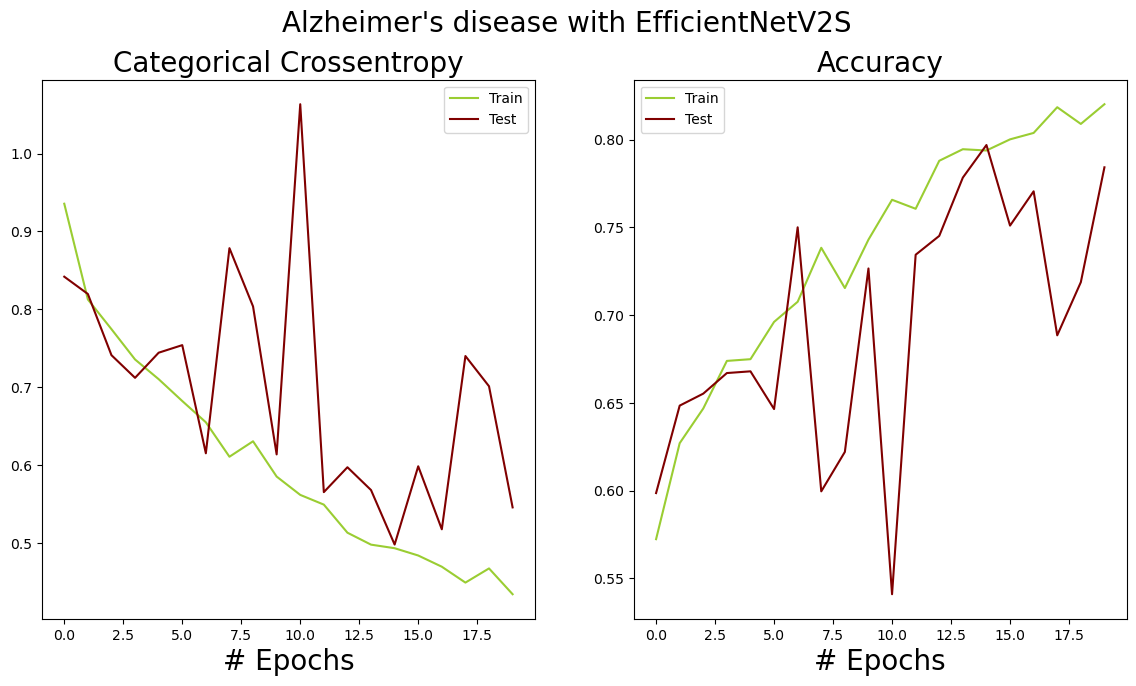

In [19]:
# Plot Crossentropy and Accuracy by epoch
functions.evaluation_plots(h_efv2s, 'Alzheimer\'s disease with EfficientNetV2S')

Accuracy_score: 0.7969 



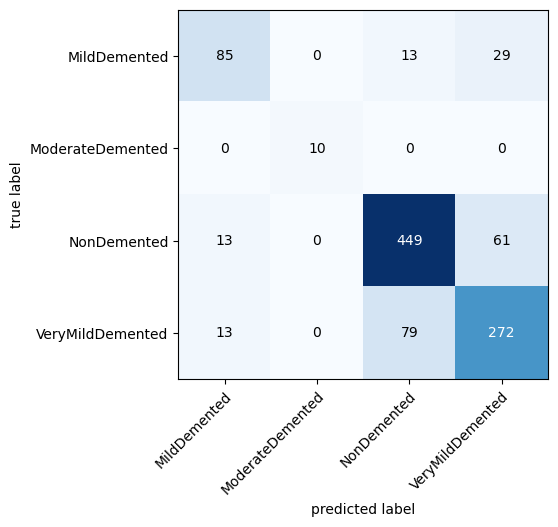

In [20]:
# Validating set Plot Confusion Matrix and print Accuracy
functions.acc_conf_matrix(model, val_data=al_val_ds_rgb)

Accuracy_score: 0.6349 



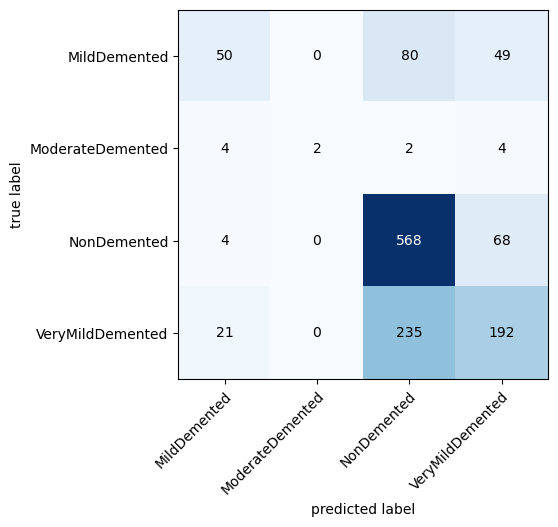

In [23]:
# Testing set Plot Confusion Matrix and print Accuracy
functions.acc_conf_matrix(model, val_data=al_test_ds_rgb)

In [15]:
es = EarlyStopping(patience = 5)

model = Sequential()

model.add(effnet)
model.add(GlobalAveragePooling2D())

#Just use a single output layer
model.add(Dense(4, activation='softmax'))

# Compile
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

h_efv2s = model.fit(X_train, y_train, validation_data = (X_val, y_val), epochs=50, callbacks = [es])

Epoch 1/50
120/120 [==============================] - 361s 3s/step - loss: 0.9343 - accuracy: 0.5565 - val_loss: 0.8472 - val_accuracy: 0.6292
Epoch 2/50
120/120 [==============================] - 327s 3s/step - loss: 0.7981 - accuracy: 0.6404 - val_loss: 0.7944 - val_accuracy: 0.6440
Epoch 3/50
120/120 [==============================] - 337s 3s/step - loss: 0.7514 - accuracy: 0.6602 - val_loss: 0.6934 - val_accuracy: 0.7041
Epoch 4/50
120/120 [==============================] - 347s 3s/step - loss: 0.7034 - accuracy: 0.6914 - val_loss: 0.6978 - val_accuracy: 0.6753
Epoch 5/50
120/120 [==============================] - 338s 3s/step - loss: 0.6841 - accuracy: 0.7065 - val_loss: 0.6670 - val_accuracy: 0.6971
Epoch 6/50
120/120 [==============================] - 334s 3s/step - loss: 0.6396 - accuracy: 0.7190 - val_loss: 0.6754 - val_accuracy: 0.7112
Epoch 7/50
120/120 [==============================] - 339s 3s/step - loss: 0.6095 - accuracy: 0.7214 - val_loss: 0.5870 - val_accuracy: 0.7408

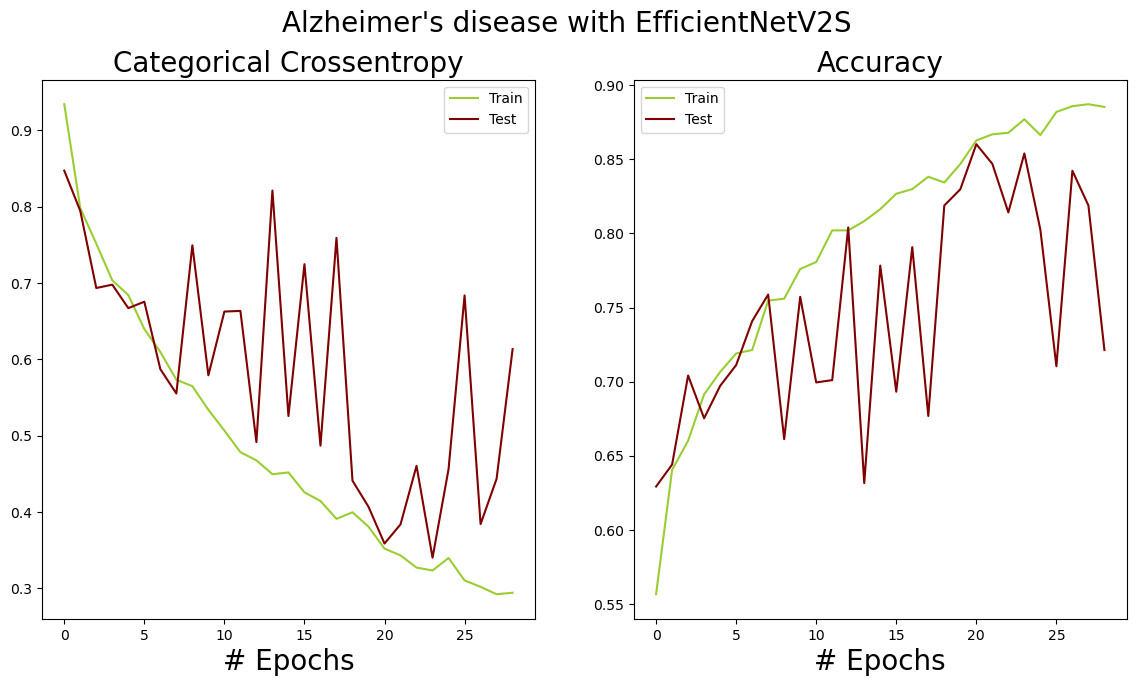

In [17]:
# Plot Crossentropy and Accuracy by epoch
functions.evaluation_plots(h_efv2s, 'Alzheimer\'s disease with EfficientNetV2S')

In [19]:
from tensorflow.math import confusion_matrix
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_confusion_matrix
import numpy as np
from sklearn.metrics import accuracy_score
from os import listdir
from tensorflow.image import grayscale_to_rgb
from tensorflow import convert_to_tensor
from tensorflow.io import read_file, decode_jpeg
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.image import resize

def acc_conf_matrix(model, val_data=None, X=None, y=None, class_names_list = None):
    '''
    '''
    # Generate Confusion Matrix
    predictions = np.array([])
    labels =  np.array([])
    if val_data == None:
        predictions = np.concatenate([predictions, model.predict(X, verbose = False).argmax(axis=1)])
        labels = np.concatenate([labels, np.argmax(y, axis=-1)])

    else:
        for x, y in val_data:
            predictions = np.concatenate([predictions, model.predict(x, verbose = False).argmax(axis=1)])
            labels = np.concatenate([labels, np.argmax(y.numpy(), axis=-1)])
    cm = confusion_matrix(labels=labels, predictions=predictions).numpy()
    # Print Accuracy score
    acc = round(accuracy_score(labels, predictions), 4)
    print(f'Accuracy_score: {acc} \n') 
    # Plot the confusion matrix
    if class_names_list:
        fig, ax = plot_confusion_matrix(cm, class_names=class_names_list)    
    else:
        fig, ax = plot_confusion_matrix(cm, class_names=val_data.class_names)

Accuracy_score: 0.7213 



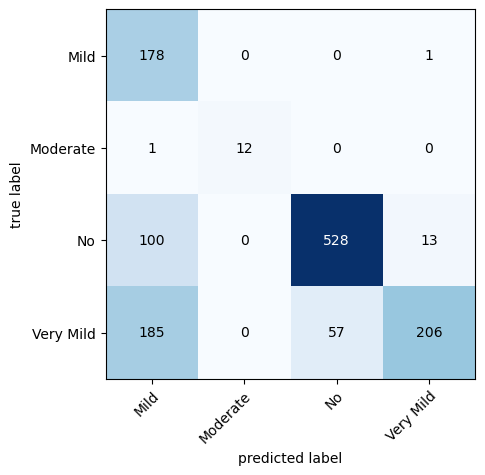

In [20]:
# Validating set Plot Confusion Matrix and print Accuracy
acc_conf_matrix(model, X=X_val, y=y_val, class_names_list =  ['Mild', 'Moderate', 'No', 'Very Mild'])

Accuracy_score: 0.5801 



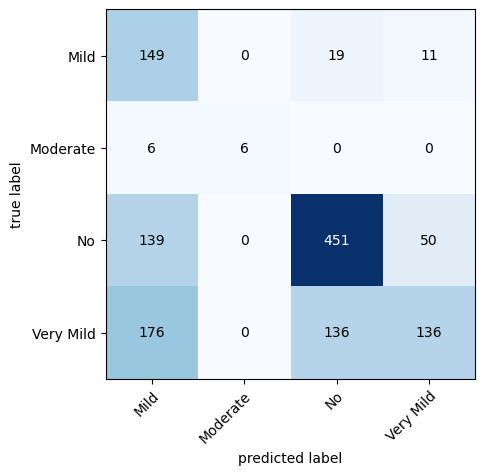

In [21]:
# Testing set Plot Confusion Matrix and print Accuracy
acc_conf_matrix(model, X=X_test, y=y_test, class_names_list =  ['Mild', 'Moderate', 'No', 'Very Mild'])

EfficientNetV2S struggles to distinguish No Alzheimer and Very Mild Alzheimer and also Mild and Very Mild Alzheimer.

---

## Xception

In [24]:
xception_model = Xception(
    include_top=False,
    weights="imagenet",
    input_shape=(image_size, image_size, 3),
    classes=4,
    classifier_activation="softmax"
)

In [25]:
# Freeze last 5 layers
for layer in xception_model.layers[:-5]:
    layer.trainable = False

In [26]:
# Read images as RGB to use in pre-trained model

model = Sequential()

model.add(xception_model)
model.add(GlobalAveragePooling2D())
model.add(Dropout(.2))
#Just use a single output layer
model.add(Dense(4, activation='softmax'))

# Compile
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

h_xc = model.fit(al_train_ds_rgb, validation_data = al_val_ds_rgb, epochs=30, callbacks=[es, reduce_lr])

Epoch 1/30
65/65 [==============================] - 223s 3s/step - loss: 0.8862 - accuracy: 0.5870 - val_loss: 1.7506 - val_accuracy: 0.5391 - lr: 0.0010
Epoch 2/30
65/65 [==============================] - 219s 3s/step - loss: 0.7860 - accuracy: 0.6441 - val_loss: 1.1924 - val_accuracy: 0.5752 - lr: 0.0010
Epoch 3/30
65/65 [==============================] - 228s 4s/step - loss: 0.7136 - accuracy: 0.6868 - val_loss: 0.8057 - val_accuracy: 0.6416 - lr: 0.0010
Epoch 4/30
65/65 [==============================] - 226s 3s/step - loss: 0.6380 - accuracy: 0.7332 - val_loss: 0.8522 - val_accuracy: 0.6152 - lr: 0.0010
Epoch 5/30
65/65 [==============================] - 189s 3s/step - loss: 0.5466 - accuracy: 0.7725 - val_loss: 1.3854 - val_accuracy: 0.4883 - lr: 0.0010
Epoch 6/30
65/65 [==============================] - 187s 3s/step - loss: 0.5295 - accuracy: 0.7884 - val_loss: 0.9522 - val_accuracy: 0.6025 - lr: 0.0010
Epoch 7/30
65/65 [==============================] - 188s 3s/step - loss: 0.4

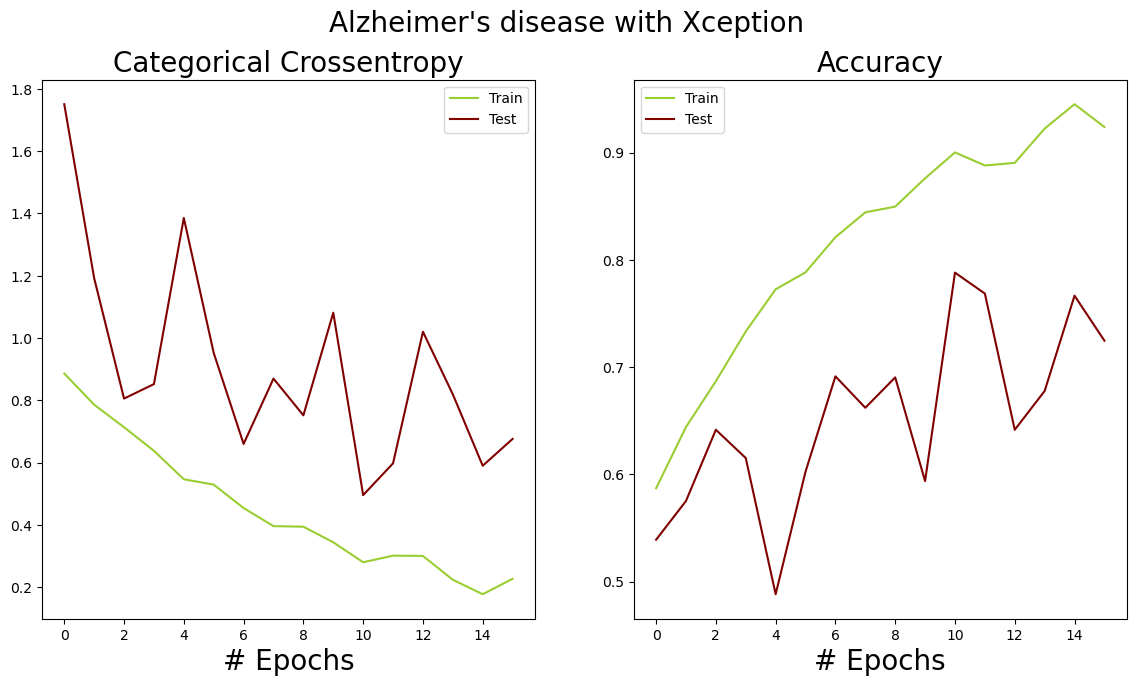

In [27]:
# Plot Crossentropy and Accuracy by epoch
functions.evaluation_plots(h_xc, 'Alzheimer\'s disease with Xception')

Accuracy_score: 0.7881 



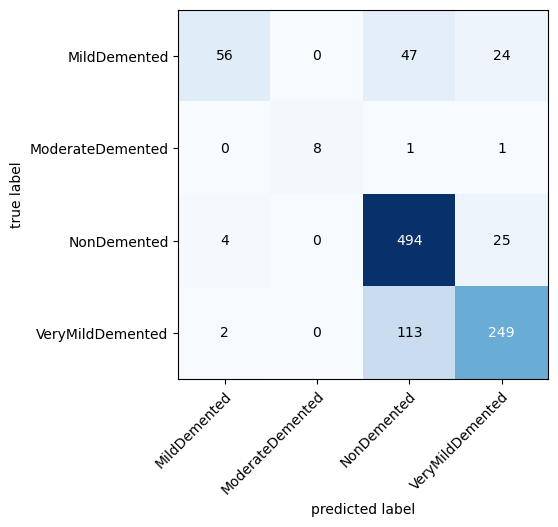

In [28]:
# Validating set Plot Confusion Matrix and print Accuracy
functions.acc_conf_matrix(model, val_data=al_val_ds_rgb)

Accuracy_score: 0.5919 



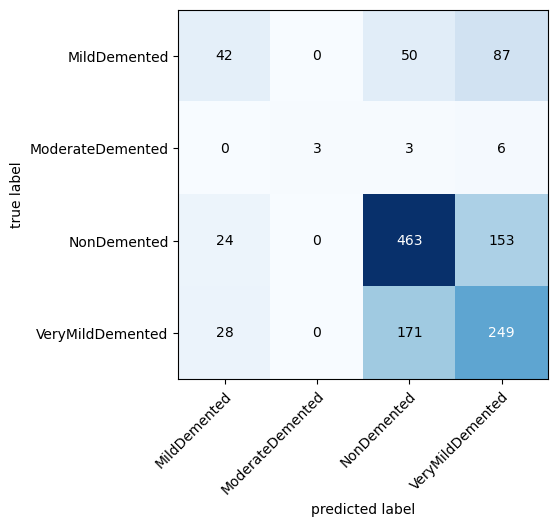

In [29]:
# Testing set Plot Confusion Matrix and print Accuracy
functions.acc_conf_matrix(model, val_data=al_test_ds_rgb)

In [24]:
es = EarlyStopping(patience = 5, restore_best_weights=True)

model = Sequential()

model.add(xception_model)
model.add(GlobalAveragePooling2D())

#Just use a single output layer
model.add(Dense(4, activation='softmax'))

# Compile
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

h_xc = model.fit(X_train, y_train, validation_data = (X_val, y_val), epochs=50, callbacks = [es])

Epoch 1/50
120/120 [==============================] - 198s 2s/step - loss: 0.8951 - accuracy: 0.5651 - val_loss: 1.0068 - val_accuracy: 0.6112
Epoch 2/50
120/120 [==============================] - 199s 2s/step - loss: 0.7774 - accuracy: 0.6479 - val_loss: 0.8208 - val_accuracy: 0.6448
Epoch 3/50
120/120 [==============================] - 200s 2s/step - loss: 0.6812 - accuracy: 0.7013 - val_loss: 1.4127 - val_accuracy: 0.5566
Epoch 4/50
120/120 [==============================] - 199s 2s/step - loss: 0.5576 - accuracy: 0.7680 - val_loss: 0.9244 - val_accuracy: 0.5933
Epoch 5/50
120/120 [==============================] - 199s 2s/step - loss: 0.4777 - accuracy: 0.8029 - val_loss: 0.8489 - val_accuracy: 0.6542
Epoch 6/50
120/120 [==============================] - 199s 2s/step - loss: 0.3704 - accuracy: 0.8518 - val_loss: 0.7360 - val_accuracy: 0.6784
Epoch 7/50
120/120 [==============================] - 200s 2s/step - loss: 0.3146 - accuracy: 0.8766 - val_loss: 0.7518 - val_accuracy: 0.7057

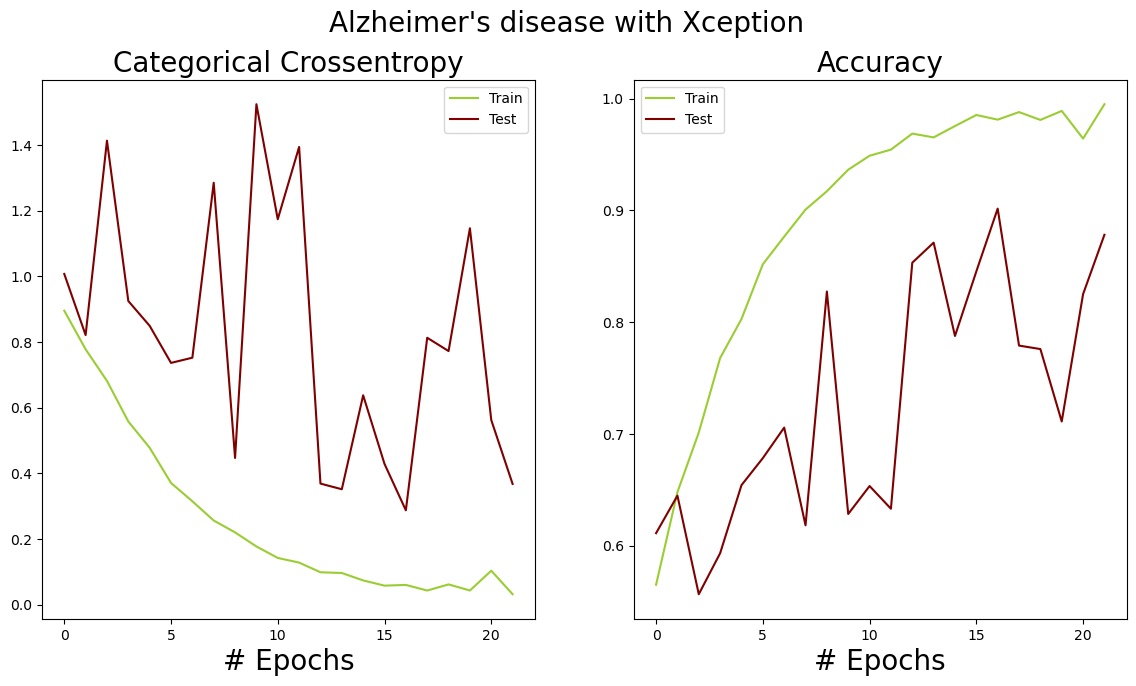

In [25]:
# Plot Crossentropy and Accuracy by epoch
functions.evaluation_plots(h_xc, 'Alzheimer\'s disease with Xception')

Accuracy_score: 0.8782 



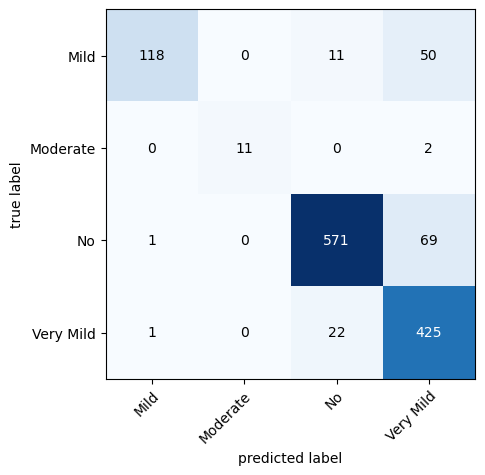

In [27]:
# Plot Confusion Matrix and print Accuracy
acc_conf_matrix(model, X=X_val, y=y_val, class_names_list =  ['Mild', 'Moderate', 'No', 'Very Mild'])

This model struggles to classify Very Mild Alzheimer.

Accuracy_score: 0.595 



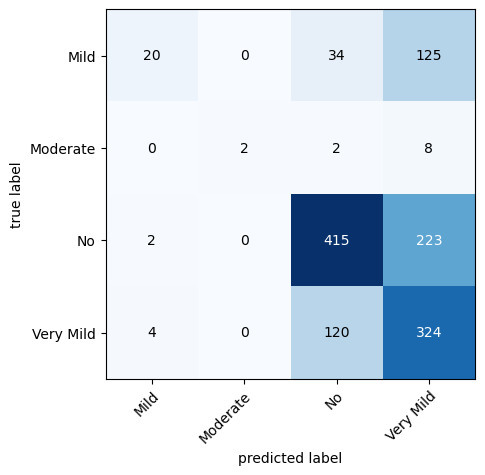

In [28]:
# Plot Confusion Matrix 
acc_conf_matrix(model, X=X_test, y=y_test, class_names_list =  ['Mild', 'Moderate', 'No', 'Very Mild'])

The predictions are hardly over 50% base line 

In [27]:
# Read the images, convert to greyscale and prepare for Tensorflow models
X_train, X_val, y_train, y_val = functions.read_grey_images_to_rgb('../data/alzheimer/train')

# Check the shape of the data
X_train.shape, y_train.shape

((3840, 240, 240, 3), (3840, 4))

In [28]:
# Prepare the training data for predictions
X_test, y_test = functions.read_grey_images_to_rgb('../data/alzheimer/test', train_test = False)

# Check the shape of the data
X_test.shape, y_test.shape

((1279, 240, 240, 3), (1279, 4))

In [29]:


rn_model = resnet50.ResNet50(
    include_top=False,
    weights="imagenet",
    input_shape=(image_size, image_size, 3),
    classes=4,
    classifier_activation="softmax"
)

In [30]:
for layer in rn_model.layers:
    layer.trainable = False

In [32]:
es = EarlyStopping(patience = 5, restore_best_weights=True)

model = Sequential()

model.add(rn_model)
model.add(Flatten())

#Just use a single output layer
model.add(Dense(4, activation='softmax'))

# Compile
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

h_rn = model.fit(al_train_ds_rgb, validation_data = al_val_ds_rgb, epochs=30, callbacks=[es, reduce_lr])

Epoch 1/50
120/120 [==============================] - 380s 3s/step - loss: 5.2764 - accuracy: 0.5997 - val_loss: 1.6225 - val_accuracy: 0.7018
Epoch 2/50
120/120 [==============================] - 388s 3s/step - loss: 0.7296 - accuracy: 0.8518 - val_loss: 0.8015 - val_accuracy: 0.8368
Epoch 3/50
120/120 [==============================] - 381s 3s/step - loss: 0.7441 - accuracy: 0.8656 - val_loss: 0.7648 - val_accuracy: 0.8673
Epoch 4/50
120/120 [==============================] - 373s 3s/step - loss: 0.3070 - accuracy: 0.9367 - val_loss: 1.8573 - val_accuracy: 0.7931
Epoch 5/50
120/120 [==============================] - 371s 3s/step - loss: 0.1566 - accuracy: 0.9612 - val_loss: 1.3677 - val_accuracy: 0.7822
Epoch 6/50
120/120 [==============================] - 374s 3s/step - loss: 0.1997 - accuracy: 0.9602 - val_loss: 0.4863 - val_accuracy: 0.9016
Epoch 7/50
120/120 [==============================] - 371s 3s/step - loss: 0.1009 - accuracy: 0.9734 - val_loss: 0.4176 - val_accuracy: 0.9157

Accuracy_score: 0.6654 



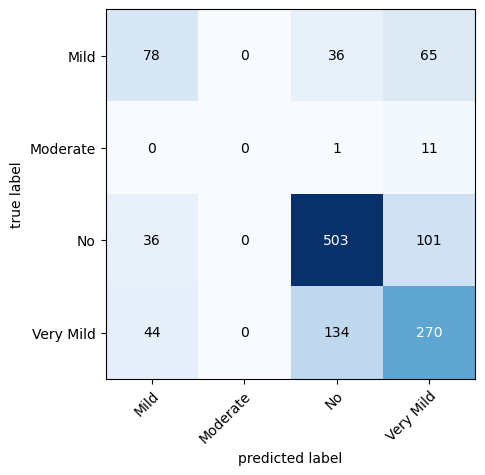

In [33]:
# Plot Confusion Matrix 
functions.acc_conf_matrix(model, X=X_test, y=y_test, class_names_list =  ['Mild', 'Moderate', 'No', 'Very Mild'])

## ResNet50

In [37]:
rn_model = resnet50.ResNet50(
    include_top=False,
    weights="imagenet",
    input_shape=(image_size, image_size, 3),
    classes=4,
    classifier_activation="softmax"
)

In [42]:
for layer in rn_model.layers:
    layer.trainable = False

In [41]:
# Read images as RGB to use in pre-trained model

model = Sequential()

model.add(rn_model)
model.add(Flatten())
model.add(Dropout(.2))

#Just use a single output layer
model.add(Dense(4, activation='softmax'))

# Compile
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

h_rn = model.fit(al_train_ds_rgb, validation_data = al_val_ds_rgb, epochs=30, callbacks=[es, reduce_lr])

Epoch 1/30
65/65 [==============================] - 251s 4s/step - loss: 4422.2632 - accuracy: 0.4415 - val_loss: 1585.3082 - val_accuracy: 0.5195 - lr: 0.0010
Epoch 2/30
65/65 [==============================] - 266s 4s/step - loss: 1625.6957 - accuracy: 0.4508 - val_loss: 3352.5728 - val_accuracy: 0.3555 - lr: 0.0010
Epoch 3/30
65/65 [==============================] - 276s 4s/step - loss: 1421.0946 - accuracy: 0.4879 - val_loss: 2644.7556 - val_accuracy: 0.3691 - lr: 0.0010
Epoch 4/30
65/65 [==============================] - 278s 4s/step - loss: 1092.4708 - accuracy: 0.5150 - val_loss: 2323.0801 - val_accuracy: 0.3457 - lr: 0.0010
Epoch 5/30
65/65 [==============================] - 244s 4s/step - loss: 1155.7455 - accuracy: 0.5092 - val_loss: 2460.1406 - val_accuracy: 0.5107 - lr: 0.0010
Epoch 6/30
65/65 [==============================] - 241s 4s/step - loss: 1111.5177 - accuracy: 0.4928 - val_loss: 1877.6740 - val_accuracy: 0.3672 - lr: 0.0010


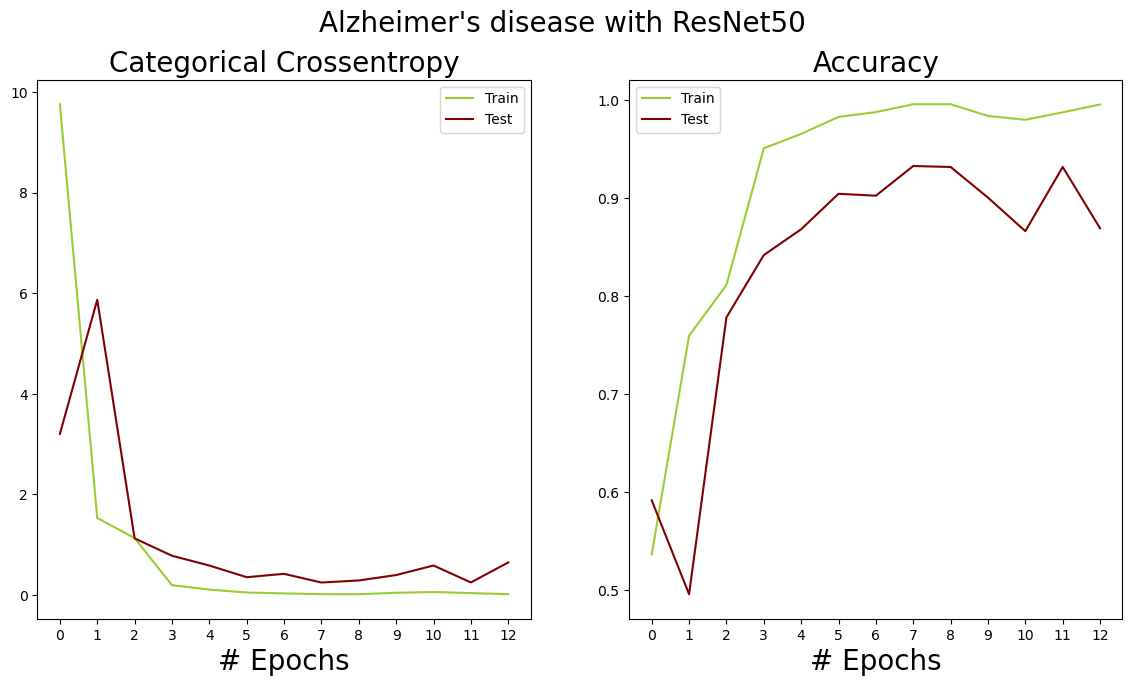

In [34]:
# Plot Crossentropy and Accuracy by epoch
functions.evaluation_plots(h_rn, 'Alzheimer\'s disease with ResNet50')

Accuracy_score: 0.9326 



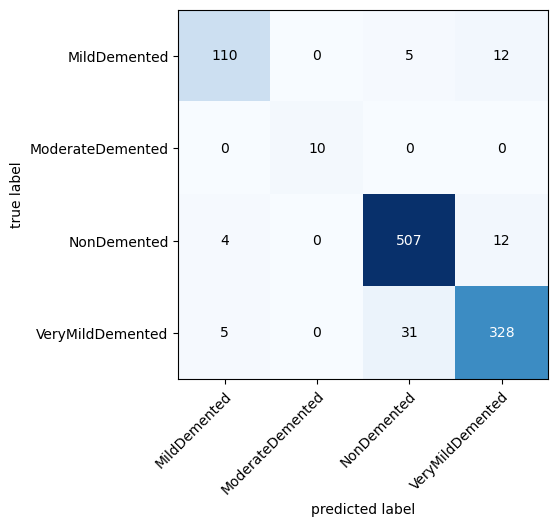

In [35]:
# Validating set Plot Confusion Matrix and print Accuracy
functions.acc_conf_matrix(model, val_data=al_val_ds_rgb)

Accuracy_score: 0.6771 



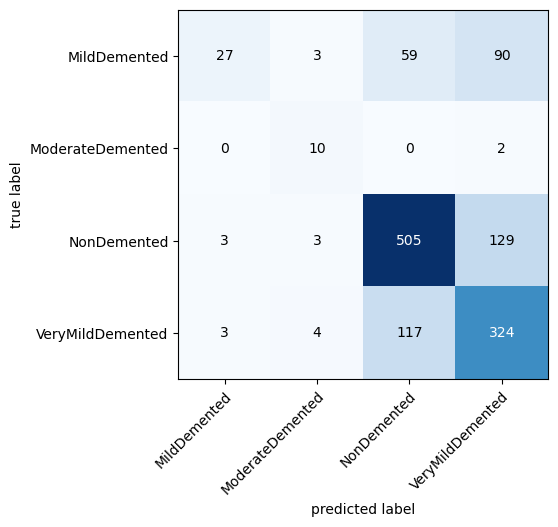

In [36]:
# Testing set Plot Confusion Matrix and print Accuracy
functions.acc_conf_matrix(model, val_data=al_test_ds_rgb)

In [18]:
es = EarlyStopping(patience = 5, restore_best_weights=True)

model = Sequential()

model.add(rn_model)
model.add(Flatten())

#Just use a single output layer
model.add(Dense(4, activation='softmax'))

# Compile
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

h_rn = model.fit(X_train, y_train, validation_data = (X_val, y_val), epochs=50, callbacks = [es])

Epoch 1/50
120/120 [==============================] - 587s 5s/step - loss: 4.8851 - accuracy: 0.6180 - val_loss: 2.5708 - val_accuracy: 0.6901
Epoch 2/50
120/120 [==============================] - 587s 5s/step - loss: 0.9690 - accuracy: 0.8341 - val_loss: 1.6726 - val_accuracy: 0.7252
Epoch 3/50
120/120 [==============================] - 574s 5s/step - loss: 0.9667 - accuracy: 0.8529 - val_loss: 0.9676 - val_accuracy: 0.8470
Epoch 4/50
120/120 [==============================] - 586s 5s/step - loss: 0.6409 - accuracy: 0.8951 - val_loss: 1.4383 - val_accuracy: 0.8205
Epoch 5/50
120/120 [==============================] - 585s 5s/step - loss: 0.6162 - accuracy: 0.9036 - val_loss: 0.9852 - val_accuracy: 0.8767
Epoch 6/50
120/120 [==============================] - 579s 5s/step - loss: 0.1398 - accuracy: 0.9724 - val_loss: 1.2213 - val_accuracy: 0.8407
Epoch 7/50
120/120 [==============================] - 661s 6s/step - loss: 0.0502 - accuracy: 0.9865 - val_loss: 0.5579 - val_accuracy: 0.9016

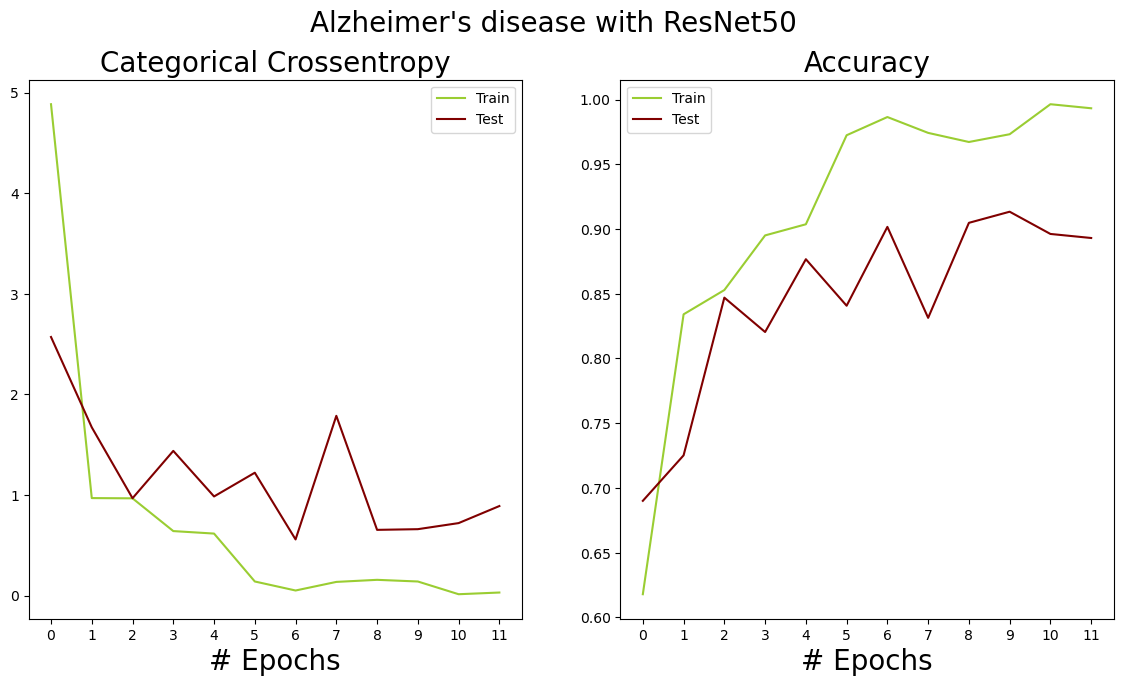

In [23]:
# Plot Crossentropy and Accuracy by epoch
functions.evaluation_plots(h_rn, 'Alzheimer\'s disease with ResNet50')

Accuracy_score: 0.9016 



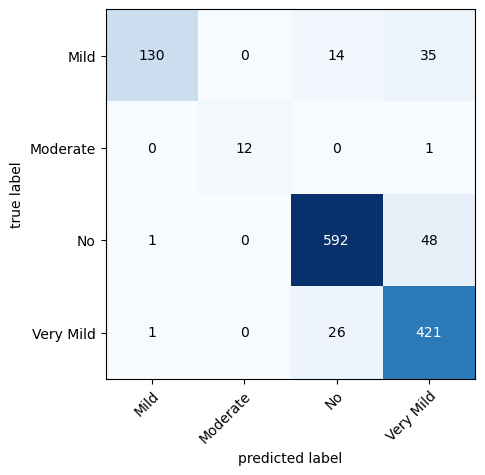

In [21]:
# Plot Confusion Matrix 
functions.acc_conf_matrix(model, X=X_val, y=y_val, class_names_list =  ['Mild', 'Moderate', 'No', 'Very Mild'])

Accuracy_score: 0.6724 



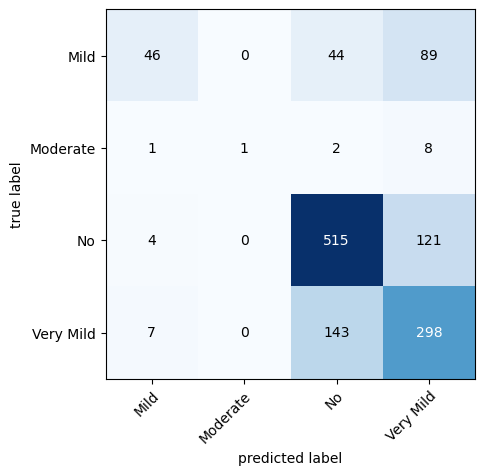

In [20]:
# Plot Confusion Matrix 
functions.acc_conf_matrix(model, X=X_test, y=y_test, class_names_list =  ['Mild', 'Moderate', 'No', 'Very Mild'])

---

The CNN and EfficientNetV2S were the best models so far with about 60% accuracy. EfficientNetV2S took a long time to train to get to this accuracy. My training accuracy is much higher. I will need to combat overfitting.
In the next notebook I will use the same models on Brain Tumor data.